# Trajectory inference with STREAM
This notebook performs trajectory inference in a custom environment and exports trajectory data to individual files for further preprocessing by Dictys in traj-step2.ipynb to integrate it into the pipeline input.

Here STREAM is used in its designated anaconda environment (https://github.com/pinellolab/STREAM and its installation instructions). This notebook is based on its tutorial (https://nbviewer.org/github/pinellolab/STREAM/blob/master/tutorial/1.1.STREAM_scRNA-seq%20%28Bifurcation%29.ipynb?flush_cache=true). Check its other tutorials if needed.

Any trajectory inference software can be used as long as it outputs the trajectory (as nodes and edges) and each cell's location on the trajectory (either as edge & location on the trajectory, or as distance to each node). See different constructors of `dictys.traj.trajectory` and `dictys.traj.point`. Only tree-shaped trajectory is allowed.

In [2]:
import os
os.environ["OMP_NUM_THREADS"] = "128"
import anndata as ad
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import stream as st
from tempfile import TemporaryDirectory
st.__version__


/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/lingfei_dynet_stream2/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:17: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


'1.0'

## Load data

In [3]:
# Input file path of low-dimensional coordinates for cells to infer trajectory
# Cells not to be included in trajectory inference should have been removed in this file
fname='../data/coord_rna.tsv.gz'
d=pd.read_csv(fname,header=0,index_col=0,sep='\t')
ns=d.shape[0]
print(d.shape)
d.head()


(6436, 2)


,x,y
Trial60.skin.R1.01.R2.02.R3.21.P1.56,1.760810,-8.762940
Trial60.skin.R1.01.R2.03.R3.61.P1.54,8.376727,-13.873216
Trial60.skin.R1.01.R2.06.R3.64.P1.56,3.499622,-8.509009
Trial60.skin.R1.01.R2.06.R3.83.P1.55,1.287024,-9.679595
Trial60.skin.R1.01.R2.11.R3.86.P1.56,1.679156,-8.890386


## Trajectory inference

In [4]:
#Parameters for STREAM
ka1={'epg_alpha':0.05,'epg_mu':0.01,'epg_lambda':0.1,'epg_trimmingradius':2}
ka2={'epg_ext_mode':'QuantDists','epg_ext_par':1.}

#Construct adata only with coordinates
adata=ad.AnnData(np.array([]).reshape(ns,0))
adata.obs = pd.DataFrame([],index=d.index)
adata.obsm['X_dr'] = d.values
with TemporaryDirectory() as td:
	#Trajectory inference
	st.set_workdir(adata,td)
	st.elastic_principal_graph(adata,**ka1)
	st.extend_elastic_principal_graph(adata,**ka2)


Saving results in: /dev/shm/lw554/tmp/tmpzfier0im
No initial structure is seeded
Learning elastic principal graph...
[1]
 "Generating the initial configuration"


[1]
 "Creating a chain in the 1st PC with 2 nodes"


[1]
 "Constructing tree 1 of 1 / Subset 1 of 1"


[1]
 "The elastic matrix is being used. Edge configuration will be ignored"


[1]
 "Computing EPG with 50 nodes on 6436 points and 2 dimensions"


[1]
 "Using a single core"


Nodes = 
2
 
3
 
4
 
5
 
6
 
7
 
8
 
9
 
10
 
11
 
12
 
13
 
14
 
15
 
16
 
17
 
18
 
19
 
20
 
21
 
22
 
23
 
24
 
25
 
26
 
27
 
28
 
29
 
30
 
31
 
32
 
33
 
34
 
35
 
36
 
37
 
38
 
39
 
40
 
41
 
42
 
43
 
44
 
45
 
46
 
47
 
48
 
49
 


BARCODE	ENERGY	NNODES	NEDGES	NRIBS	NSTARS	NRAYS	NRAYS2	MSE	MSEP	FVE	FVEP	UE	UR	URN	URN2	URSD

1||50
	
0.5861
	
50
	
49
	
46
	
1
	
0
	
0
	
0.267
	
0.2634
	
0.9726
	
0.973
	
0.3076
	
0.0115
	
0.5748
	
28.74
	
0




/data/pinello/SHARED_SOFTWARE/anaconda_latest/envs/lingfei_dynet_stream2/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang

  warnings.warn(x, RRuntimeWarning)


58.518 sec elapsed

[[1]]



Number of branches after learning elastic principal graph: 3
Extending leaves with additional nodes ...
Number of branches after extending leaves: 3


## Trajectory visualization
Adjust parameters in the previous step to make sure you are happy with the inferred trajectory. Consider having several annotated low-dimensional plots (e.g. with cell type, read count, etc) at the side for trajectory evaluation. Record cell type/developmental stage annotations of the nodes (S0, ...) for future dynamic GRN analyses.

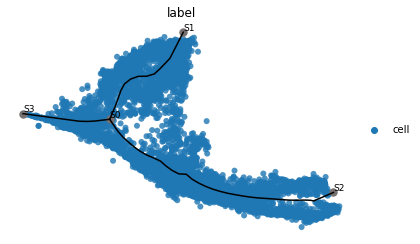

In [5]:
adata.obs['label'] = 'cell'
st.plot_dimension_reduction(adata,show_graph=True,show_text=True)
ax=plt.gca()
ax.set_aspect(1)
ax.axis('off');


## Output trajectory
Extraction

In [6]:
dimnodes=np.array(sorted([x[:-len('_pseudotime')] for x in adata.obs.columns if x.endswith('_pseudotime')]))
dist=np.array([adata.obs.loc[d.index,x+'_pseudotime'].values for x in dimnodes]).T
ndict=dict(zip(dimnodes,range(len(dimnodes))))
branch=np.array([sorted([ndict[y] for y in x]) for x in list(adata.obs.loc[d.index,'branch_id_alias'])])
edge=np.unique(branch,axis=0)


Formatting

In [7]:
#The branch each cell is on
branch=pd.DataFrame(branch,index=d.index)
branch.head()

,0,1
Trial60.skin.R1.01.R2.02.R3.21.P1.56,0,1
Trial60.skin.R1.01.R2.03.R3.61.P1.54,0,2
Trial60.skin.R1.01.R2.06.R3.64.P1.56,0,1
Trial60.skin.R1.01.R2.06.R3.83.P1.55,0,1
Trial60.skin.R1.01.R2.11.R3.86.P1.56,0,1


In [8]:
#Distance from each cell to all nodes
dist=pd.DataFrame(dist,index=d.index,columns=dimnodes)
dist.head()

,S0,S1,S2,S3
Trial60.skin.R1.01.R2.02.R3.21.P1.56,1.796973,2.377683,10.384121,4.781205
Trial60.skin.R1.01.R2.03.R3.61.P1.54,8.058921,12.233577,0.528227,11.043153
Trial60.skin.R1.01.R2.06.R3.64.P1.56,3.439011,0.735645,12.026159,6.423243
Trial60.skin.R1.01.R2.06.R3.83.P1.55,1.028344,3.146313,9.615491,4.012575
Trial60.skin.R1.01.R2.11.R3.86.P1.56,1.677695,2.496962,10.264842,4.661926


In [9]:
#Edge existence between nodes
edge=pd.DataFrame(edge)
edge.head()

,0,1
0,0,1
1,0,2
2,0,3


Exporting

In [11]:
dist.to_csv('../tmp/dist.tsv.gz',header=True,index=True,sep='\t')
edge.to_csv('../tmp/edge.tsv.gz',header=False,index=False,sep='\t')
branch.to_csv('../tmp/branch.tsv.gz',header=False,index=False,sep='\t')
